In [1]:
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from genaibook.core import get_device

/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
device = get_device()

## Image to Image Generation

In [ ]:
img2img_pipeline = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)

In [ ]:
img2img_pipeline.to(device)

In [3]:
from genaibook.core import SampleURL, load_image, image_grid

In [ ]:
url = SampleURL.ToyAstronauts
init_image = load_image(url)
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

In [ ]:
image = img2img_pipeline(prompt, image=init_image, strength=0.7).images[0] # strength = noise. 0 = no noise --> original image. 1 ignores OG image
image_grid([init_image, image], rows=1, cols=2)

## Inpainting

In [ ]:
inpaint_pipeline = img2img_pipeline # no changes :D

In [ ]:
img_url = SampleURL.DogBenchImage
mask_url = SampleURL.DogBenchMask
init_image = load_image(img_url).convert("RGB").resize((1024, 1024))
mask_image = load_image(mask_url).convert("RGB").resize((1024, 1024))
image_grid([init_image, mask_image], rows=1, cols=2)

In [ ]:
prompt = "A singular, majestic tiger sitting on a bench"
image = inpaint_pipeline(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    num_inference_steps=50,
    strength=0.8,
    width=init_image.size[0],
    height=init_image.size[1]
).images[0]
image

In [ ]:
image_grid([init_image, mask_image, image], rows=1, cols=3)

In [ ]:
from diffusers import DiffusionPipeline

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

## Weighting Text Prompts

In [ ]:
from compel import Compel, ReturnedEmbeddingsType

In [ ]:
embeddings_type = (
    ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED
)
compel = Compel(
    tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2],
    text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
    returned_embeddings_type=embeddings_type,
    requires_pooled=[False, True]
)

In [ ]:
prompts = []
prompts.append("A humanoid robot eating pasta")
prompts.append("a humanoid+++ robot eating pasta") # Humanoid characteristic is more pronounced
prompts.append('["a humanoid robot eating pasta", "a van gogh painting].and(0.8, 0.2)') # Make it van gogh

In [ ]:
images = []
for prompt in prompts:
    # Use same seed across generations
    generator = torch.Generator(device=device).manual_seed(42)
    conditioning, pooled = compel(prompt)
    image = pipeline(
        prompt_embeds=conditioning,
        pooled_prompt_embeds=pooled,
        num_inference_steps=30,
        generator=generator
    ).images[0]
    images.append(image)
image_grid(images, rows=1, cols=3)

In [ ]:
prompts = []
prompts.append("A humanoid robot eating pasta+++")
prompts.append("a humanoid+++ robot eating pasta---")
prompts.append("a humanoid+++ robot eating (pasta)1.2")

In [ ]:
images = []
for prompt in prompts:
    # Use same seed across generations
    generator = torch.Generator(device=device).manual_seed(21)
    conditioning, pooled = compel(prompt)
    image = pipeline(
        prompt_embeds=conditioning,
        pooled_prompt_embeds=pooled,
        num_inference_steps=30,
        generator=generator
    ).images[0]
    images.append(image)
image_grid(images, rows=1, cols=3)

In [ ]:
from diffusers import SemanticStableDiffusionPipeline

semantic_pipeline = SemanticStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

generator = torch.Generator(device=device).manual_seed(99)
out = semantic_pipeline(
    prompt="a photo of the face of a man",
    negative_prompt="low quality, deformed",
    generator=generator
)
out.images[0]

##  Semantic Guidance (SEGA)
Dynamically adjusts noise, performing semantic edits in latent space based on textual descriptions

In [ ]:
generator = torch.Generator(device=device).manual_seed(99)
out = semantic_pipeline(
    prompt="a photo of the face of a man",
    negative_prompt="low quality, deformed",
    editing_prompt="smiling, smile",
    edit_guidance_scale=4,
    edit_warmup_steps=10,
    edit_threshold=0.99,
    edit_momentum_scale=0.3,
    edit_mom_beta=0.6,
    reverse_editing_direction=False,
    generator=generator
)
out.images[0]

In [ ]:
generator = torch.Generator(device=device).manual_seed(99)
out = semantic_pipeline(
    prompt="a photo of the face of a man",
    negative_prompt="low quality, deformed",
    editing_prompt="glasses, wearing glasses",
    edit_guidance_scale=4,
    edit_warmup_steps=10,
    edit_threshold=0.99,
    edit_momentum_scale=0.3,
    edit_mom_beta=0.6,
    reverse_editing_direction=False,
    generator=generator
)
out.images[0]

In [ ]:
generator = torch.Generator(device=device).manual_seed(99)
out = semantic_pipeline(
    prompt="a photo of the face of a man",
    negative_prompt="low quality, deformed",
    editing_prompt=[
        "smiling, smile",
        "glasses, wearing glasses"
    ],
    edit_guidance_scale=[4, 4],
    edit_warmup_steps=[10, 10],
    edit_threshold=[0.99, 0.99],
    edit_momentum_scale=0.3,
    edit_mom_beta=0.6,
    reverse_editing_direction=[False, False],
    generator=generator
)
out.images[0]

## LEDITS++ (SEGA + inversion)

In [4]:
from diffusers import LEditsPPPipelineStableDiffusion

In [5]:
pipe = LEditsPPPipelineStableDiffusion.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16"
)
pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

This pipeline only supports DDIMScheduler and DPMSolverMultistepScheduler. The scheduler has been changed to DPMSolverMultistepScheduler.


LEditsPPPipelineStableDiffusion {
  "_class_name": "LEditsPPPipelineStableDiffusion",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
url = "https://images.unsplash.com/photo-1698032697546-40af707fcd7f?q=80&w=3272&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
image = load_image(SampleURL.ManInGlasses).convert("RGB").resize((512, 512))

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/diffusers/image_processor.py:147: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


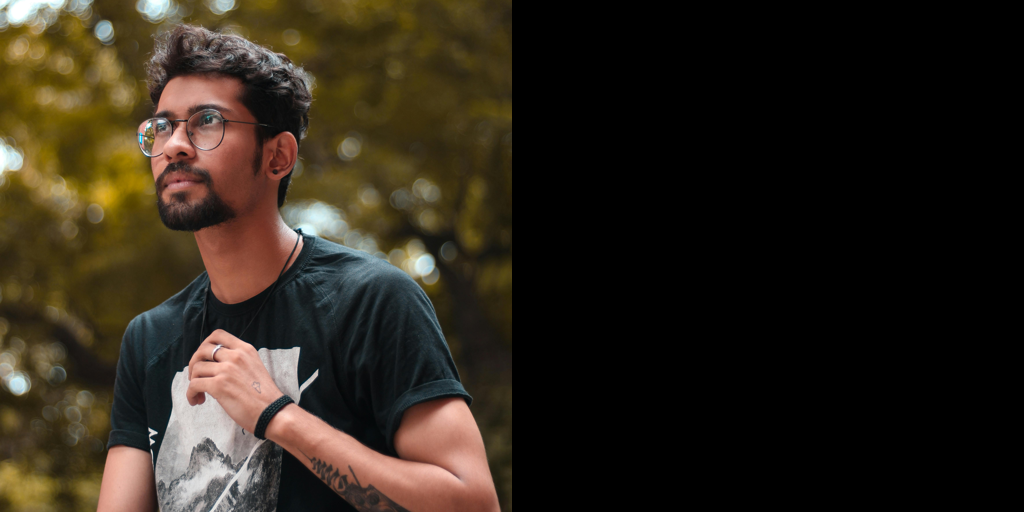

In [ ]:
# pipe.invert(image=image, num_inversion_steps=50, skip=0.2)
edited_image = pipe(
    editing_prompt=["glasses"],
    reverse_editing_direction=[True],
    edit_guidance_scale=[1.0],
    edit_threshold=[1.0]
).images[0]
image_grid([image, edited_image], rows=1, cols=2)
# I AM MAD THIS KEEPS SAYING NSFW IT IS NOT, I EVEN DID A BOAT AND IT SAID NSFW DUMB DUMB DUMB


In [11]:
from diffusers import (
    EDMEulerScheduler,
    StableDiffusionXLInstructPix2PixPipeline
)

In [12]:
from huggingface_hub import hf_hub_download

In [14]:
edit_file = hf_hub_download(repo_id="stabilityai/cosxl", filename="cosxl_edit.safetensors")

cosxl_edit.safetensors:   0%|          | 0.00/6.94G [00:00<?, ?B/s]

In [15]:
pipe_edit = StableDiffusionXLInstructPix2PixPipeline.from_single_file(
    edit_file, num_in_channels=8, is_cosxl_edit=True, torch_dtype=torch.float16
)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
pipe_edit.scheduler = EDMEulerScheduler(
    sigma_min=0.002,
    sigma_max=120.0,
    sigma_data=1.0,
    prediction_type="v_prediction",
    sigma_schedule="exponential"
)
pipe_edit.to(device)

StableDiffusionXLInstructPix2PixPipeline {
  "_class_name": "StableDiffusionXLInstructPix2PixPipeline",
  "_diffusers_version": "0.32.2",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EDMEulerScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [18]:
prompt = "make it a cloudy day"
image = load_image(SampleURL.Mountain)
edited_image = pipe_edit(
    prompt=prompt,
    image=image,
    num_inference_steps=20
).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

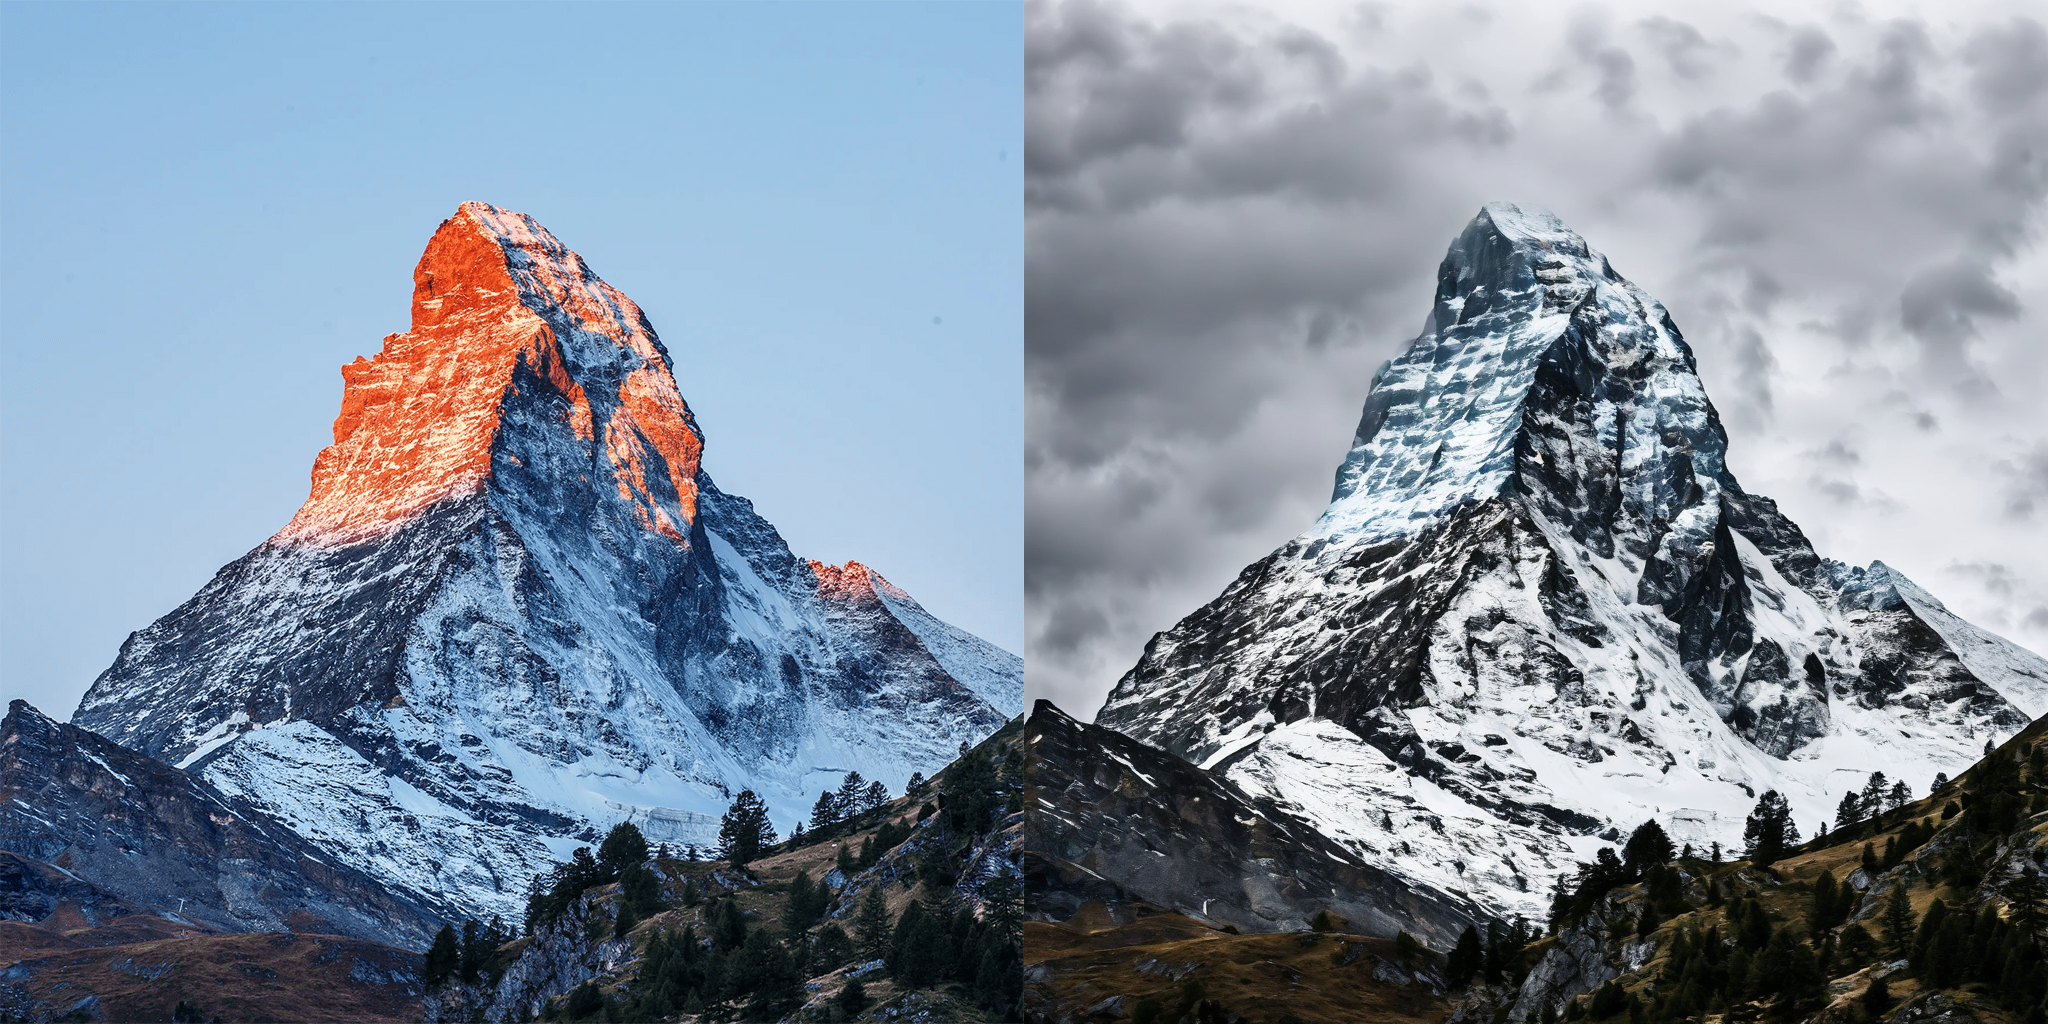

In [ ]:
image_grid([image, edited_image], rows=1, cols=2)

## Control UNet - Run on Google Colab
No worky on Mac

In [20]:
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

In [21]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    torch_dtype=torch.float16,
    variant="fp16"
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

In [22]:
controlnet_pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    variant="fp16"
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
controlnet_pipeline.enable_model_cpu_offload() # optional saving VRAM
controlnet_pipeline.to(device)

StableDiffusionXLControlNetPipeline {
  "_class_name": "StableDiffusionXLControlNetPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [24]:
from controlnet_aux import MidasDetector
from PIL import Image

In [25]:
original_image = load_image(SampleURL.WomanSpeaking)
original_image = original_image.resize((1024, 1024))

In [26]:
midas = MidasDetector.from_pretrained("lllyasviel/Annotators")

dpt_hybrid-midas-501f0c75.pt:   0%|          | 0.00/493M [00:00<?, ?B/s]

In [27]:
processed_image_midas = midas(original_image).resize((1024, 1024), Image.BICUBIC)

In [28]:
image = controlnet_pipeline(
    "A colorful, ultra-realistic masked superhero singing a song",
    image=processed_image_midas,
    controlnet_conditioning_scale=0.4,
    num_inference_steps=30
).images[0]
image_grid([original_image, processed_image_midas, image], rows=1, cols=3)

AssertionError: Torch not compiled with CUDA enabled